In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
DATA = '../../data/'

In [2]:
# Load the data
descriptors = loading.get_descriptors(format='True')
sets = ['training','leaderboard']
all_CIDs = []
for set_ in sets:
    all_CIDs += loading.get_CIDs(set_)
all_CIDs = sorted(all_CIDs)
mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian',],all_CIDs)

Dragon has 4869 features for 407 molecules.
Episuite has 62 features for 407 molecules.
Morgan has 2437 features for 407 molecules.
NSPDK has 5392 features for 407 molecules.
NSPDK Gramian has 2437 features for 407 molecules.
There are now 15197 total features.


In [3]:
# Create the feature and descriptor arrays 
X_forest,good1,good2,means,stds,imputer = dream.make_X(mdx,sets)
# -1 removes the CID; -6 removes six NaN-heavy episuite features; +2 adds the dilution information
assert len(good1) == len(mdx[0]) -1 +2 -6
Y_all,imputer = dream.make_Y_obs(sets,target_dilution=None,imputer='mask')

The X matrix now has shape (814x13380) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Load or compute the random forest model

In [4]:
if True: 
    # Load or compute the random forest model correlations (obtained from cross-validation)
    from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
    #trans_params = params.get_trans_params(Y_all, descriptors, plot=False)
    use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

    def compute_importance_ranks(X,Y,n_estimators=50,
                      max_features='auto',
                      max_depth=None,min_samples_leaf=1,
                      random_state=0):
        importances = np.zeros((21,X.shape[1])) # Empty matrix to store feature importances.  
        importance_ranks = np.zeros((21,X.shape[1])) # Empty matrix to store feature importance ranks.  
        for col in range(0,21): # For each descriptor.  
            print(col)
            observed = Y[:,col] # Perceptual data for this descriptor.  
            if col==0:
                est = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,n_jobs=8,random_state=random_state)
            else:
                est = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,oob_score=False,n_jobs=8,random_state=random_state)
            est.fit(X,observed) # Fit the model on the training data.  
            importances[col,:] = est.feature_importances_
            importance_ranks[col,:] = np.argsort(est.feature_importances_)[::-1] # Use feature importances to get ranks.  

        return importances,importance_ranks

    importances,importance_ranks = compute_importance_ranks(X_forest[:,:-1],Y_all['mean_std'],n_estimators=50)
    np.save('../../data/importances_forest',importances)
    np.save('../../data/importance_ranks_forest',importance_ranks)
else:
    importances = np.load('../../data/importances_forest.npy')
    importance_ranks = np.load('../../data/importance_ranks_forest.npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [5]:
nspdk_CIDs = pd.read_csv('%s/derived/nspdk_cid.csv' % DATA, header=None, dtype='int').as_matrix().squeeze()
nspdk_dict = dream.make_nspdk_dict(all_CIDs)
nspdk_feature_numbers = list(nspdk_dict.keys())
x = pd.read_table('%s/DREAM_episuite_descriptors.txt' % DATA,index_col=0).drop('SMILES',1)
x = x.loc[all_CIDs]
x.iloc[:,47] = 1*(x.iloc[:,47]=='YES ')
episuite_names = list(x)
episuite = x.as_matrix()
_,good = dream.purge1_X(episuite)
episuite_names = [e for i,e in enumerate(episuite_names) if i in good]
    
with open('%s/morgan_sim.csv' % DATA) as f:
     x = f.readline()
     morgan_template_CIDs = [int(xi) for xi in x.split(',')[1:]]
    
assert len(morgan_template_CIDs) == len(nspdk_CIDs) == 2437

In [6]:
from utils import loading
headers,_ = loading.load_molecular_data()
dragon_feature_names = headers[1:]
# Replace with nspdkgramian range with nspdk_CIDs
all_feature_names = ['dragon_%s' % s for s in dragon_feature_names] + \
                    ['episuite_%s' % x for x in episuite_names] + \
                    ['morgan_%d' % x for x in morgan_template_CIDs] + \
                    ['nspdk_%s' % s for s in nspdk_feature_numbers] + \
                    ['nspdkgramian_%d' % i for i in range(2437)] + ['conc_absolute','conc_relative']
good_feature_names = [all_feature_names[i] for i in good2]
good_feature_names = good_feature_names[:-1] # Remove relative dilution since we didn't use this for the fit
assert(len(good_feature_names) == importance_ranks.shape[1])

In [7]:
new_ranks = pd.DataFrame(importances.T,index=good_feature_names,columns=descriptors)
old_ranks = pd.read_csv('/Users/rgerkin/Desktop/feature_importances.csv',index_col=0)
old_ranks.columns = descriptors
old_ranks.drop('conc_relative',inplace=True)
#old_ranks.drop([s for s in list(old_ranks.index) if 'episuite_' in s],inplace=True)

new_ranks.drop('conc_absolute',inplace=True)
old_ranks.drop('conc_absolute',inplace=True)

In [8]:
desc = 'Bakery'
from IPython.display import display
#pd.set_option('display.precision',2)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
display(new_ranks.sort_values(desc,ascending=False)[[desc]].head(10))
display(old_ranks.sort_values(desc,ascending=False)[[desc]].head(10))

,Bakery
nspdkgramian_1938,0.0667
morgan_12127,0.0663
morgan_8768,0.0373
nspdkgramian_199,0.0320
nspdkgramian_757,0.0297
nspdkgramian_43,0.0296
nspdk_722140,0.0292
nspdk_214067,0.0199
nspdkgramian_1697,0.0168
nspdk_250366,0.0164


,Bakery
nspdk_253902,0.0635
nspdk_1022278,0.0624
nspdk_722140,0.0615
nspdk_250366,0.0579
nspdk_555472,0.0567
nspdk_544811,0.0522
nspdk_214067,0.0518
nspdk_430273,0.0513
nspdk_199698,0.0356
nspdk_410940,0.0167


In [9]:
nspdk_CIDs[1249],nspdk_CIDs[764],nspdk_CIDs[390]

(36314, 8767, 62902)

Intensity
	0 -> 0 (dragon_B03[C-S])
	1 -> 1 (dragon_F03[C-S])
	2 -> 2 (dragon_Eig07_AEA(dm))
	3 -> 11 (dragon_Eig08_AEA(dm))
	4 -> 7 (dragon_O-057)
	5 -> 6 (dragon_C-028)
	6 -> 1698 (dragon_H-049)
	7 -> 4 (dragon_Mor30p)
	8 -> 44 (dragon_Eig10_AEA(dm))
	9 -> 46 (dragon_SpAbs_B(s))
Pleasantness
	0 -> 0 (nspdkgramian_1249)
	1 -> 6 (dragon_RDF015s)
	2 -> 3 (dragon_SssO)
	3 -> 1 (nspdkgramian_764)
	4 -> 8 (dragon_MAXDP)
	5 -> 7 (dragon_P_VSA_i_1)
	6 -> 2 (morgan_90978)
	7 -> 4 (dragon_P_VSA_MR_8)
	8 -> 13 (nspdkgramian_390)
	9 -> 53 (dragon_RDF025s)
Bakery
	0 -> 22 (nspdk_253902)
	1 -> 14 (nspdk_1022278)
	2 -> 6 (nspdk_722140)
	3 -> 9 (nspdk_250366)
	4 -> 18 (nspdk_555472)
	5 -> 15 (nspdk_544811)
	6 -> 7 (nspdk_214067)
	7 -> 21 (nspdk_430273)
	8 -> 16 (nspdk_199698)
	9 -> 20 (nspdk_410940)
Sweet
	0 -> 0 (nspdkgramian_390)
	1 -> 7 (nspdkgramian_199)
	2 -> 9 (morgan_102861)
	3 -> 4 (morgan_8467)
	4 -> 39 (nspdk_939920)
	5 -> 16 (nspdk_338410)
	6 -> 25 (morgan_158410)
	7 -> 13 (nspdk_248294)


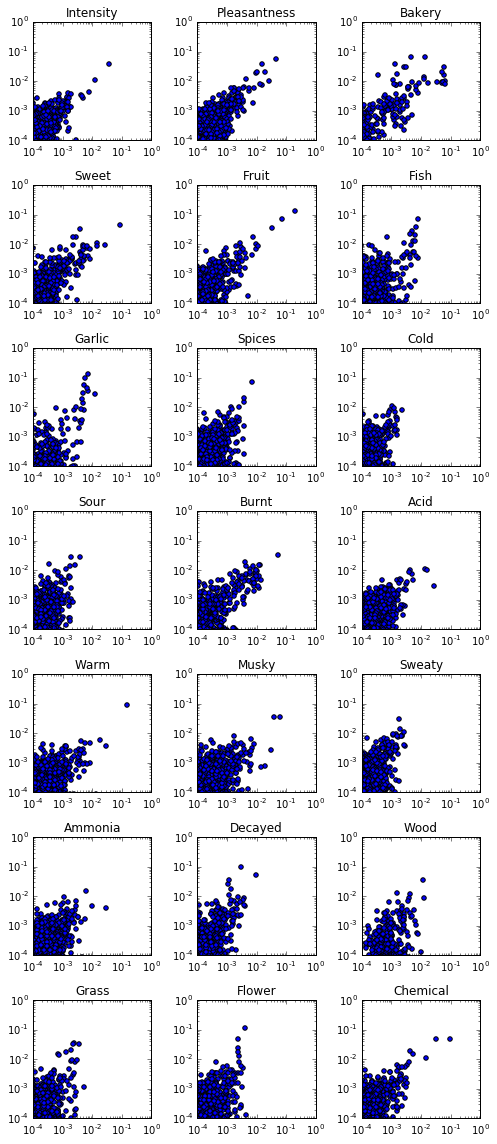

In [10]:
diff = list(set(list(old_ranks.index)).difference(new_ranks.index))
old_ranks_2 = old_ranks.drop(diff,0).loc[new_ranks.index]
fig,axes = plt.subplots(7,3,figsize=(7,16))
for i,desc in enumerate(descriptors):
    old_sorted = list(old_ranks_2.sort_values(desc,ascending=False).index)
    new_sorted = list(new_ranks.sort_values(desc,ascending=False).index)
    print(desc)
    for j in range(10):
        old_name = old_sorted[j]
        print("\t%d -> %d (%s)" % (j,new_sorted.index(old_name),old_name))
    ax = axes.flat[i]
    #print(desc)
    old = old_ranks_2[desc]
    new = new_ranks[desc]
    ax.scatter(old,new)
    ax.set_xlim(0.0001,1)
    ax.set_ylim(0.0001,1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(desc)
plt.tight_layout()